# Modelisation non-supervisee

## A. Pre-requis & Nettoyage

In [1]:
# Chargement des librairies necessaires

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE

In [2]:
# Chargement du dataset

df = pd.read_csv('dataset/dataset-clean-v2.csv')

In [3]:
# Fonction pour nettoyer et convertir en liste les colonnes du dataset

def convert_columns(text):
    """
    Convertit une chaîne de caractères en liste de mots en remplaçant certains caractères spéciaux et en séparant les éléments.

    Args:
        text (str): La chaîne de caractères à traiter. Celle-ci peut contenir des crochets, des virgules et des guillemets.

    Returns:
        list: Une liste de mots extraits de la chaîne, avec les caractères spéciaux remplacés par des espaces.
    """
    return text.replace("[", " ").replace("]", " ").replace(",", " ").replace("'", " ").split()

In [4]:
# Appliquer la fonction 'convert_columns' aux variables 'preproc_tags', 'preproc_body', 'preproc_title'

df['preproc_title'] = df['preproc_title'].apply(convert_columns)
df['preproc_body'] = df['preproc_body'].apply(convert_columns)
df['preproc_tags'] = df['preproc_tags'].apply(convert_columns)

In [5]:
# Garder les variables pertinentes

df = df[['preproc_tags', 'preproc_title', 'preproc_body']]

In [6]:
df.head()

,preproc_tags,preproc_title,preproc_body
0,"[linux, winapi, visual-c++, unix, timer]","[gettimeofday, guarantee, microsecond, resolut...","[port, game, originally, write, win32, api, li..."
1,"[c#, sql, vb.net, ascii, hex]","[decode, sql, cast]","[recently, site, deluge, resurgence, asprox, b..."
2,"[c#, winforms, flash, adobe, macromedia]","[display, flash, content, winforms, application]","[good, way, display, flash, content, winforms,..."
3,"[sql, sql-server, sql-server-2005, indexing, f...","[sql, text, indexing, return, result, word, co...","[instance, query, like, follow, sql, server, s..."
4,"[apache-flex, eclipse, unit-testing, build-aut...","[unit, test, flex, application, ide, build, sc...","[currently, work, application, frontend, write..."


## B. Features Engineering

In [7]:
# Creer un corpus unique

df['corpus'] = df['preproc_title'].apply(' '.join) + ' ' + df['preproc_body'].apply(' '.join)

## C. Modelisation LDA avec Bag of Words

In [8]:
# Initialisation du vectoriseur BoW
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')  # Ajuste ces paramètres si nécessaire
X_bow = vectorizer.fit_transform(df['corpus'])

# Affichage de la forme de la matrice BoW (documents x termes)
print(f"BoW shape: {X_bow.shape}")

BoW shape: (50000, 36332)


In [9]:
# Initialisation du modèle LDA
lda_model = LatentDirichletAllocation(n_components=10, random_state=42)  # n_components est le nombre de topics

# Entraînement du modèle LDA
lda_model.fit(X_bow)

LatentDirichletAllocation(random_state=42)

In [10]:
# Afficher les mots les plus importants pour chaque topic
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10  # Nombre de mots à afficher par topic
display_topics(lda_model, vectorizer.get_feature_names_out(), no_top_words)

Topic 0:
control class object asp model property net new set like
Topic 1:
function return int new code var null string error void
Topic 2:
table sql database select query column row value key datum
Topic 3:
file server use like work script project way run application
Topic 4:
time thread use datum like need memory good way question
Topic 5:
class public java org method new error void private object
Topic 6:
application run code test service web work error windows use
Topic 7:
string xml array like value text character way code use
Topic 8:
user request page url php send post app message form
Topic 9:
image text work html jquery div page javascript button click


In [11]:
# Associer chaque question à un topic
topic_distributions = lda_model.transform(X_bow)

# Affichage des topics les plus probables pour les premières questions
for i in range(5):  # Par exemple, pour les 5 premières questions
    print(f"Question {i}: Topic distribution - {topic_distributions[i]}")

Question 0: Topic distribution - [0.00200028 0.12997504 0.0020003  0.10876103 0.29076371 0.00200023
 0.45849833 0.00200054 0.00200025 0.00200028]
Question 1: Topic distribution - [6.45293195e-04 6.45344341e-04 9.95213432e-02 6.45384863e-04
 6.45308924e-04 6.45245403e-04 1.16586228e-01 7.79375222e-01
 6.45326782e-04 6.45303601e-04]
Question 2: Topic distribution - [0.13129977 0.00294268 0.00294156 0.3304749  0.00294199 0.0029413
 0.00294185 0.00294167 0.00294194 0.51763234]
Question 3: Topic distribution - [0.00277837 0.00277834 0.68016214 0.00277816 0.00277809 0.00277819
 0.00277814 0.29761219 0.00277815 0.00277823]
Question 4: Topic distribution - [0.04111653 0.00263183 0.0026318  0.50127011 0.00263192 0.0026322
 0.43918998 0.00263188 0.00263184 0.0026319 ]


## D. Visualisation des topics en 2D

In [12]:
# Appliquer t-SNE pour réduire les topics à 2 dimensions
tsne_model = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
tsne_lda = tsne_model.fit_transform(topic_distributions)

# Afficher la forme des données réduites
print(f"t-SNE LDA shape: {tsne_lda.shape}")

t-SNE LDA shape: (50000, 2)


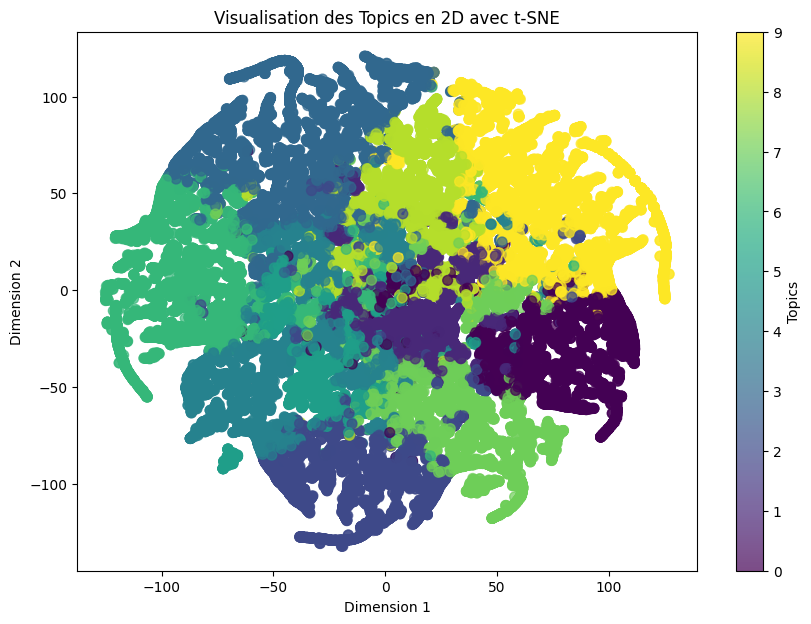

In [13]:
# Créer un plot pour visualiser les topics dans l'espace 2D
plt.figure(figsize=(10, 7))

# Colorier les points selon les topics prédominants
plt.scatter(tsne_lda[:, 0], tsne_lda[:, 1], c=topic_distributions.argmax(axis=1), cmap='viridis', s=50, alpha=0.7)

# Ajouter un titre et des axes
plt.title("Visualisation des Topics en 2D avec t-SNE")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")

# Afficher la barre de couleurs pour correspondre aux topics
plt.colorbar(label='Topics')

# Afficher le graphique
plt.show()